In [2]:
import pandas as pd 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from sortedcontainers import SortedList
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
import tensorflow as tf


# Preprocessing 

In [9]:
df=pd.read_csv('../data/edited_rating.csv')

In [91]:
N = df.User.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies
print(N,M)

6040 3706


# Split data 


In [14]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

## sparse matrix 

In [93]:
A = lil_matrix((N, M))

def update_train(row):
  i = int(row.User)
  j = int(row.movie_idx)
  A[i,j] = row.Rating
df_train.apply(update_train, axis=1)

693169    None
542514    None
168285    None
491772    None
717552    None
          ... 
359502    None
789407    None
459487    None
169733    None
242444    None
Length: 800167, dtype: object

In [94]:
A_test = lil_matrix((N, M))

def update_test(row):
  i = int(row.User)
  j = int(row.movie_idx)
  A_test[i,j] = row.Rating
df_test.apply(update_test, axis=1)

46356     None
879590    None
472266    None
206911    None
522526    None
          ... 
36626     None
560188    None
742968    None
445839    None
339454    None
Length: 200042, dtype: object

In [95]:
# train
A = A.tocsr()
mask = (A > 0)
save_npz("Atrain.npz", A)

# test 
A_test = A_test.tocsr()
mask_test = (A_test > 0)
save_npz("Atest.npz", A_test)

# Model

In [96]:
# initialize variables
batch_size = 128
epochs = 20
reg = 0.0001

In [97]:
A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

In [98]:
# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

In [99]:
N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

N: 6040 M: 3706
N // batch_size: 47
mu: 3.5821472267664127


In [80]:
# build the model 
i = Input(shape=(M,))
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

In [100]:
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)  # Ensure y_true is float32
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = tf.reduce_sum(sqdiff)
    n = tf.reduce_sum(mask)
    return sse / n

In [101]:
def generator(A, M):
    while True:
        A, M = shuffle(A, M)
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            a = a - mu * m  # must keep zeros at zero!
            noisy = a  # no noise for now
            yield noisy, a

In [102]:
def test_generator(A, M, A_test, M_test):
    while True:
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            at = A_test[i*batch_size:upper].toarray()
            mt = M_test[i*batch_size:upper].toarray()
            a = a - mu * m
            at = at - mu * mt
            yield a, at

In [81]:
model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(learning_rate=0.01, momentum=0.9),
  metrics=[custom_loss],
) # loss & metrics are mse -> will not be the same if we use regularization 

In [82]:
r = model.fit(
    generator(A, mask),
    validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
    epochs=40,
    steps_per_epoch=A.shape[0] // batch_size + 1,
    validation_steps=A_test.shape[0] // batch_size + 1,
)

Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - custom_loss: 1.3282 - loss: 1.5635 - val_custom_loss: 1.2515 - val_loss: 1.4864
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - custom_loss: 1.2842 - loss: 1.5191 - val_custom_loss: 1.2148 - val_loss: 1.4490
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - custom_loss: 1.2429 - loss: 1.4771 - val_custom_loss: 1.1725 - val_loss: 1.4062
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - custom_loss: 1.2028 - loss: 1.4363 - val_custom_loss: 1.1267 - val_loss: 1.3598
Epoch 5/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - custom_loss: 1.1487 - loss: 1.3819 - val_custom_loss: 1.0837 - val_loss: 1.3164
Epoch 6/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - custom_loss: 1.0931 - loss: 1.3259 - val_custom_loss: 1.0474 - val_loss: 1.2799
Epoch 7/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - custom_loss: 1.0594 - loss: 1.2917 - val_custom_loss: 1.0178 - val_loss: 1.2501
Epoch 8/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - custom_loss: 1.0

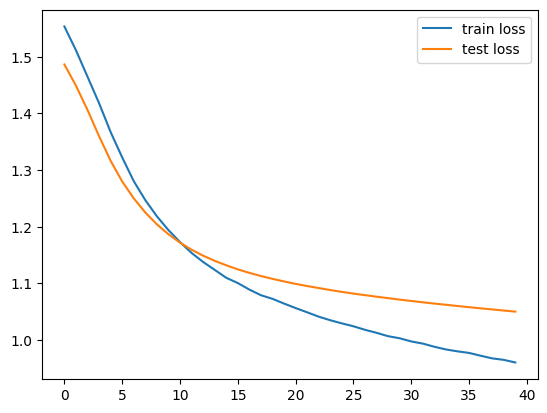

In [84]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()


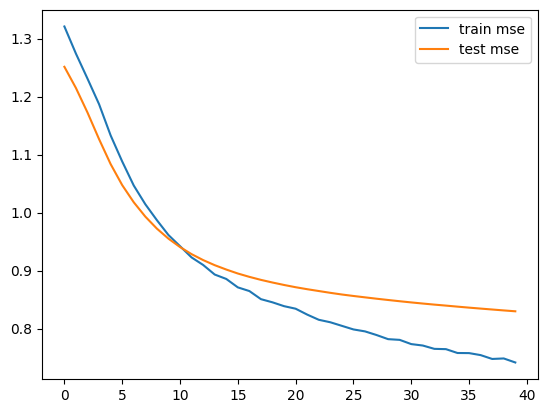

In [85]:
# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

In [86]:
model.save('model_AutoEncoder.h5') 

# single prediction 

In [1]:
from tensorflow.keras.models import load_model

In [4]:
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)  # Ensure y_true is float32
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = tf.reduce_sum(sqdiff)
    n = tf.reduce_sum(mask)
    return sse / n

In [5]:
# Load the model
model = load_model('model_AutoEncoder.h5', custom_objects={'custom_loss': custom_loss})

A = load_npz("Atrain.npz")

with open('mu.pkl', 'rb') as f:
  mu = pickle.load(f)

In [140]:
# def predict_rating(user_id, movie_id, A, mask, model, mu):

#     # Extract the specific row (user's interactions)
#     A_single = A[user_id].toarray()  # Convert to dense array

#     # mask_single = mask[user_id].toarray()  # Mask for that user
    
#     # Preprocess the input (subtract the mean where mask is 1)
#     # A_single_processed = A_single - mu * mask_single

#     A_single_processed = A_single - mu
    
#     # Make a prediction for the entire row (all movies for this user)
#     prediction = model.predict(A_single_processed.reshape(1, -1))
    
#     # Add the mean back to the predicted values
#     prediction_rescaled = prediction + mu 
    
#     # Return the predicted rating for the specific movie
#     predicted_rating = prediction_rescaled[0, movie_id]
    
#     return predicted_rating

In [6]:
def predict_rating(user_id, movie_id, model, A, mu):
    # Get the user ratings (row for user_id)
    user_ratings = A[user_id].toarray()  # Convert sparse matrix to dense if necessary
    
    # Center the data (subtract the global average, mu)
    user_ratings = user_ratings - mu * (user_ratings > 0)
    
    # Get the prediction for this user (entire row)
    user_prediction = model.predict(user_ratings)

    prediction_rescaled = user_prediction + mu
    
    # Retrieve the predicted rating for the specific movie_id
    predicted_rating = prediction_rescaled[0][movie_id]
    
    return predicted_rating

In [7]:
def existence(user_id , movie_id):
    rate=df[(df.User == user_id) & (df.movie_idx == movie_id)].Rating.values
    if len(rate)!=0:
            print(f"{(user_id, movie_id)} exists in the data with value : {rate[0]} ")
    else:
            print(f"{(user_id, movie_id)} does not exist in the data ")

In [10]:
print(predict_rating(1381, 46, model, A, mu))
existence(1381, 46)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3.60909
(1381, 46) does not exist in the data 


In [11]:
print(predict_rating(5773, 863, model, A, mu))
existence(5773  , 863)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3.8649185
(5773, 863) exists in the data with value : 4 


In [12]:
print(predict_rating(128, 497, model, A, mu))
existence(128, 497)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3.2492728
(128, 497) exists in the data with value : 4 


In [15]:
df_train.head(20)

,User,Movie,Rating,movie_idx
355819,2910,3615,5,3375
21438,196,3147,4,2931
551203,4387,3175,4,2958
265120,2070,3510,3,3277
900783,3664,364,5,354
1566,17,421,4,407
649830,5224,372,4,362
668926,5386,2363,3,2170
947002,4707,1007,2,942
726423,5837,1230,4,1139


In [16]:
print(predict_rating(4121, 3461, model, A, mu))
existence(4121, 3461)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3.7919502
(4121, 3461) exists in the data with value : 3 


In [17]:
df_test.head(20)

,User,Movie,Rating,movie_idx
588444,4681,2010,4,1830
761425,304,2629,1,2427
808811,1424,1612,2,1480
370634,3031,3114,4,2898
818033,1641,3074,3,2859
677221,5457,3683,3,3441
78445,691,70,3,68
36262,325,1333,3,1236
851660,2435,3108,4,2892
182068,1464,3685,4,3443
